In [0]:
from google.colab import drive
drive.mount('/content/drive/')
root_path = 'drive/My Drive/qqp-nlp-project/'

In [2]:
%cd $root_path

/content/drive/My Drive/qqp-nlp-project


In [0]:
!pip install -U bcolz

In [0]:
!pip install -U scikit-learn

In [8]:
!python train.py --max_epochs 20 --batch_size 64 --is_pretrained --lr 0.005

Namespace(batch_size=64, cos_sim_dim=20, debug=False, embed_dim=300, is_pretrained=True, lr=0.005, max_epochs=20, patience=5)
Train set: No. of question pairs: 323429
Validation set: No. of question pairs: 40429
Test set: No. of question pairs: 40429
Vocabulary size:  101083
words_found: 68017
| epoch   1 |     1/ 5054 batches | loss 0.69477778673172
| epoch   1 |    11/ 5054 batches | loss 0.6854583566839044
| epoch   1 |    21/ 5054 batches | loss 0.6778580461229596
| epoch   1 |    31/ 5054 batches | loss 0.662278369549782
| epoch   1 |    41/ 5054 batches | loss 0.6579274404339674
| epoch   1 |    51/ 5054 batches | loss 0.6523308005987429
| epoch   1 |    61/ 5054 batches | loss 0.6463637615813583
| epoch   1 |    71/ 5054 batches | loss 0.6421827547986743
| epoch   1 |    81/ 5054 batches | loss 0.6379685519654074
| epoch   1 |    91/ 5054 batches | loss 0.634442632669931
| epoch   1 |   101/ 5054 batches | loss 0.6286261506599955
| epoch   1 |   111/ 5054 batches | loss 0.622212

In [0]:
from random import randint
from extract_data import load_and_split_data, extract_data
from models.infersent_model import InferSent
from torch.utils.data import Dataset, DataLoader

import numpy as np
import time
import torch
import os
import sys
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def get_infersent_model():

    # Load model
    model_version = 1
    MODEL_PATH = "encoder/infersent%s.pkl" % model_version
    params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
    model = InferSent(params_model)
    model.load_state_dict(torch.load(MODEL_PATH))

    # Keep it on CPU or put it on GPU
    use_cuda = True if torch.cuda.is_available() else False
    model = model.cuda() if use_cuda else model
    # If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
    W2V_PATH = 'data/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
    model.set_w2v_path(W2V_PATH)
    # Load embeddings of K most frequent words
    model.build_vocab_k_words(K=100000)

    return model

In [8]:
train_data, val_data, test_data = extract_data(file_path='./data/train.csv')#load_and_split_data(file_path='./data/train.csv')

Train set: No. of question pairs: 323429
Validation set: No. of question pairs: 40429
Test set: No. of question pairs: 40429


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
infersent_encoder = get_infersent_model()

In [0]:
train_q1_embedding = infersent_encoder.encode(train_data['q1s'], bsize=64, tokenize=True, verbose=False)
train_q2_embedding = infersent_encoder.encode(train_data['q2s'], bsize=64, tokenize=True, verbose=False)
train_dataset = {'q1s':train_q1_embedding, 'q2s':train_q2_embedding,'labels':train_data['labels']}

In [0]:
val_q1_embedding = infersent_encoder.encode(val_data['q1s'], bsize=64, tokenize=True, verbose=False)
val_q2_embedding = infersent_encoder.encode(val_data['q2s'], bsize=64, tokenize=True, verbose=False)
val_dataset = {'q1s':val_q1_embedding, 'q2s':val_q2_embedding,'labels':val_data['labels']}

In [0]:
test_q1_embedding = infersent_encoder.encode(test_data['q1s'], bsize=64, tokenize=True, verbose=False)
test_q2_embedding = infersent_encoder.encode(test_data['q2s'], bsize=64, tokenize=True, verbose=False)
test_dataset = {'q1s':test_q1_embedding, 'q2s':test_q2_embedding,'labels':test_data['labels']}

In [0]:
class QQPDataset(Dataset):
    """Quora Question Pairs dataset."""

    def __init__(self, data, device=None, debug=False):
        self.device = device
        if debug:
            self.q1_embeds = data['q1s'][:64]
            self.q2_embeds = data['q2s'][:64]
            self.labels = data['labels'][:64]
        else:
            self.q1_embeds = data['q1s']
            self.q2_embeds = data['q2s']
            self.labels = data['labels']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = {'q1':torch.from_numpy(self.q1_embeds[idx]).to(device),
                  'q2':torch.from_numpy(self.q2_embeds[idx]).to(device),
                  'label':self.labels[idx]}
        return sample


Model

In [0]:
class MLPClassifier(nn.Module):
    """MLPClassifier model"""

    def __init__(self, embed_dim=4096):
        super(MLPClassifier, self).__init__()
        self.inp_dim = 2*embed_dim + 2
        self.classifier = nn.Sequential(
          nn.Linear(self.inp_dim, self.inp_dim // 2),
          nn.ReLU(),
          nn.Linear(self.inp_dim//2, self.inp_dim // 4),
          nn.ReLU(),
          nn.Linear(self.inp_dim//4, self.inp_dim // 4),
          nn.ReLU(),
          nn.Linear(self.inp_dim//4, 1),
        )
       
        self.criterion = nn.BCEWithLogitsLoss(reduction='mean')

    def forward(self, q1_embedding, q2_embedding):
        # q1_out = self.mlp_layers(q1_embedding)
        # q2_out = self.mlp_layers(q2_embedding)
        cosine_sim = F.cosine_similarity(q1_embedding, q2_embedding, dim=-1).unsqueeze(-1)
        dot_product = torch.sum(q1_embedding * q2_embedding, dim=-1, keepdim=True)
        inp = torch.cat((q1_embedding,q2_embedding,cosine_sim,dot_product), dim=-1)
        logits = self.classifier(inp)
        return logits.squeeze()

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def train(epoch, data_loader, model, optimizer):
    model.train()
    total_loss = 0.
    start_time = time.time()
    acc = 0.

    for i, batch in enumerate(data_loader):
        q1_embedding = batch['q1']
        q2_embedding = batch['q2']
        true_labels = batch['label'].to(dtype=torch.float).to(device)

        optimizer.zero_grad()

        output_logits = model(q1_embedding, q2_embedding)
        loss = model.criterion(output_logits, true_labels)
        
        loss.backward()
        optimizer.step()
        
        output_logits = output_logits.detach()
        pred_labels = (torch.sigmoid(output_logits) > 0.5).to(dtype=torch.float)
        count = torch.sum(pred_labels == true_labels).to(dtype=torch.float)
        acc += count.item() / len(true_labels)
        # print(pred_labels[:10],true_labels[:10])
        total_loss += loss.item()

        if i % 200 == 0:
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'loss {}'.format(epoch, (i + 1), len(data_loader),
                                   total_loss / (i + 1)))
    accuracy = acc / len(data_loader)
    avg_loss = total_loss / len(data_loader)
    print('|Epoch {:3d} | accuracy {}'.format(epoch, accuracy))
    return avg_loss, accuracy, model


In [0]:
def evaluate(eval_model, data_loader):
    eval_model.eval()
    total_loss = 0.
    acc = 0.
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            q1_embedding = batch['q1']
            q2_embedding = batch['q2']
            true_labels = batch['label'].to(dtype=torch.float).to(device)

            output_logits = model(q1_embedding, q2_embedding)
            loss = model.criterion(output_logits, true_labels)
            
            total_loss += loss.item()

            pred_labels = (torch.sigmoid(output_logits) > 0.5).to(dtype=torch.float)
            count = torch.sum(pred_labels == true_labels).to(dtype=torch.float)
            acc += count.item() / len(true_labels)
            # print(pred_labels[:10],true_labels[:10])

    accuracy = acc / len(data_loader)
    avg_loss = total_loss / len(data_loader)

    return avg_loss, accuracy

Dataset and dataloader

In [0]:
train_set = QQPDataset(train_dataset, device, debug=False)
val_set = QQPDataset(val_dataset, device, debug=False)
test_set = QQPDataset(test_dataset, device, debug=False)

In [0]:
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=False)

In [0]:
model = MLPClassifier(embed_dim=4096)
model.to(device)
count_parameters(model)

50368519

In [0]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [0]:
lr = 0.001  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.1,
                                                    #    patience=5, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 50
k = 0
patience = 8
best_val_loss = np.inf
best_val_acc = 0.0
best_epoch = 0
best_model = None
train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_loss, train_acc, model = train(epoch, train_dataloader, model, optimizer)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    val_loss, val_acc = evaluate(model, val_dataloader)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {} | '.format(epoch,
                                                                            (time.time(
                                                                            ) - epoch_start_time),
                                                                            val_loss))
    print('|Epoch {:3d} | valid accuracy {}'.format(epoch, val_acc))
    print('-' * 89)

    if val_acc > best_val_acc:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_model = model
        best_epoch = epoch
        torch.save(model.state_dict(), "./best_model.pt")
        k = 0
    elif k < patience:
        k += 1
    else:
        break
    scheduler.step()
    print('Epoch:{} | lr: {}'.format(epoch, get_lr(optimizer)))

print('Best val loss: {} | acc: {} at epoch {}'.format(
    best_val_loss, best_val_acc, best_epoch))
test_loss, test_acc = evaluate(best_model, test_dataloader)
print('Test | loss: {} | acc: {}'.format(
    test_loss, test_acc))

In [0]:
import pickle
result = pickle.load(open(f'./log_results.pkl', 'rb'))

In [0]:
train_accs = result['train_acc']
val_accs = result['val_acc']
train_losses = result['train_loss']
val_losses = result['val_loss']

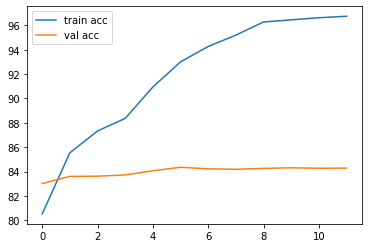

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_accs)), train_accs, label='train acc')
plt.plot(np.arange(len(train_accs)), val_accs, label='val acc')
plt.legend()
plt.show()

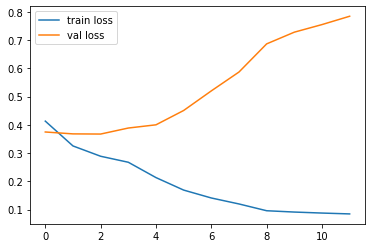

In [8]:
plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')
plt.plot(np.arange(len(train_losses)), val_losses, label='val loss')
plt.legend()
plt.show()

In [9]:
result['best_acc'], result['test_acc']

(84.35428753516175, 83.98877021800281)

In [10]:
np.argmax(val_accs)

5

In [0]:
import pickle
val_true = np.concatenate(pickle.load(open(f'./best_val_true_labels.pkl', 'rb')))
val_pred = np.concatenate(pickle.load(open(f'./best_val_pred_labels.pkl', 'rb')))

y_test = np.concatenate(pickle.load(open(f'./test_true_labels.pkl', 'rb')))
y_pred = np.concatenate(pickle.load(open(f'./test_pred_labels.pkl', 'rb')))

Confusion matrix, without normalization
[[22173  3329]
 [ 2996 11931]]


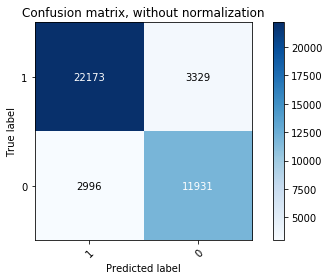

Normalized confusion matrix
[[0.87 0.13]
 [0.2  0.8 ]]


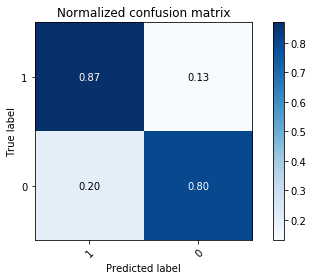

In [20]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [1,0]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(val_true, val_pred, title='Confusion matrix, without normalization')
plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(val_true, val_pred, normalize=True, title='Normalized confusion matrix')
plt.show()

Confusion matrix, without normalization
[[22180  3323]
 [ 3149 11777]]


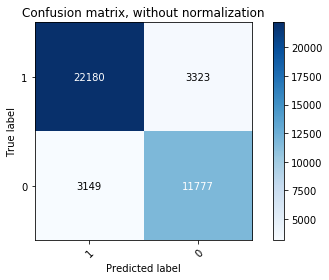

Normalized confusion matrix
[[0.87 0.13]
 [0.21 0.79]]


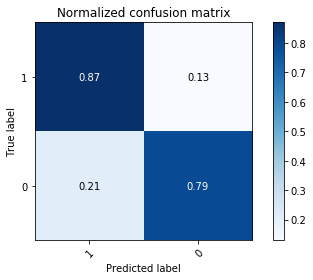

In [24]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, title='Confusion matrix, without normalization')
plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True, title='Normalized confusion matrix')
plt.show()